## Importing libs

In [1]:
#From https://mne.tools/stable/auto_examples/simulation/simulate_raw_data.html#sphx-glr-auto-examples-simulation-simulate-raw-data-py
import matplotlib.pyplot as plt
import numpy as np
import mne
from mne import Epochs, compute_covariance, find_events, make_ad_hoc_cov
from mne.datasets import sample
from mne.simulation import (
    add_ecg,
    add_eog,
    add_noise,
    simulate_raw,
    simulate_sparse_stc,
    
)
from mne.minimum_norm import apply_inverse, make_inverse_operator
from mne.beamformer import apply_lcmv, make_lcmv
from mne.datasets import fetch_fsaverage, sample

### Loading data for experimental setup from mne sample


In [2]:
data_path = sample.data_path()
meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_raw.fif"
fwd_fname = meg_path / "sample_audvis-meg-eeg-oct-6-fwd.fif"
subjects_dir = data_path / "subjects"
raw = mne.io.read_raw_fif(raw_fname)
noise_cov=mne.read_cov(meg_path / "sample_audvis-cov.fif")
subject = "sample"
annot = "aparc.a2009s"
sfreq =raw.info["sfreq"]
tstep = 1 /sfreq
fwd = mne.read_forward_solution(fwd_fname)
src = fwd["src"]


Opening raw data file /home/hp/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...


    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
    366 x 366 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading forward solution from /home/hp/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named m

In [3]:
raw.pick(["meg","stim"])

Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,MEG
Participant,Unknown
Digitized points,146 points
Good channels,"203 Gradiometers, 102 Magnetometers, 9 Stimulus"
Bad channels,MEG 2443
EOG channels,Not available
ECG channels,Not available
Sampling frequency,600.61 Hz
Highpass,0.10 Hz
Lowpass,172.18 Hz


In [4]:
src1=mne.setup_source_space(subject, spacing='ico5', surface='white', subjects_dir=subjects_dir, add_dist=True)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /home/hp/mne_data/MNE-sample-data/subjects
Subject      = sample
Surface      = white
Icosahedron subdivision grade 5

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading /home/hp/mne_data/MNE-sample-data/subjects/sample/surf/lh.white...
Mapping lh sample -> ico (5) ...
    Triangle neighbors and vertex normals...
Loading geometry from /home/hp/mne_data/MNE-sample-data/subjects/sample/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 10242/155407 selected to source space (ico = 5)

Loading /home/hp/mne_data/MNE-sample-data/subjects/sample/surf/rh.white...
Mapping rh sample -> ico (5) ...
    Triangle neighbors and vertex normals...
Loading geometry from /home/hp/mne_data/MNE-sample-data/subjects/sample/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 10242/156866 selected to source space (ico = 5

KeyboardInterrupt: 

In [9]:
src1.save(meg_path/"sample_audvis-ico5-src.fif")

    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


In [13]:
# I think provided distances are only for neighbouring vertces and others are computed as 0
gdist_vertices= src1[0]["dist"][src1[0]["vertno"][:,np.newaxis],src1[0]["vertno"]].toarray()


Using surface: /home/hp/mne_data/MNE-sample-data/subjects/sample/bem/inner_skull.surf
Using surface: /home/hp/mne_data/MNE-sample-data/subjects/sample/bem/outer_skull.surf
Using surface: /home/hp/mne_data/MNE-sample-data/subjects/sample/bem/outer_skin.surf


/home/hp/miniconda3/envs/mne/lib/python3.12/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


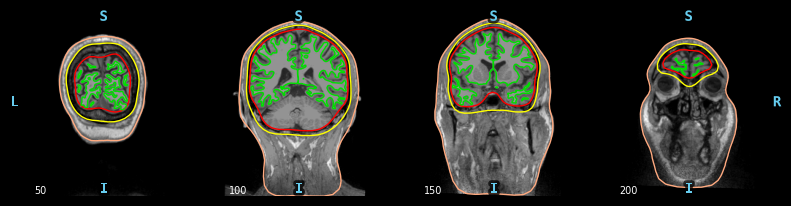

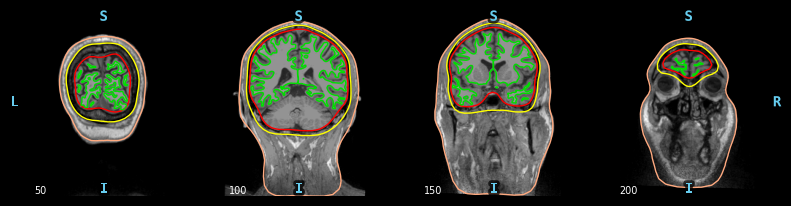

In [15]:
plot_bem_kwargs = dict(
    subject=subject,
    subjects_dir=subjects_dir,
    brain_surfaces="white",
    orientation="coronal",
    slices=[50, 100, 150, 200],
)

mne.viz.plot_bem(**plot_bem_kwargs)

In [ ]:
trans = meg_path / "sample_audvis_raw-trans.fif"
info = mne.io.read_info(raw_fname)


In [29]:
# The transformation file obtained by coregistration
trans = meg_path / "sample_audvis_raw-trans.fif"

conductivity = (0.3,)  # for single layer
# conductivity = (0.3, 0.006, 0.3)  # for three layers
model = mne.make_bem_model(
    subject="sample", ico=5, conductivity=conductivity, subjects_dir="/home/hp/Documents/AUDITORY_MEG/"
)
bem = mne.make_bem_solution(model)

Creating the BEM geometry...
Going from 5th to 5th subdivision of an icosahedron (n_tri: 20480 -> 20480)
inner skull CM is   0.25 -14.58  36.13 mm
Surfaces passed the basic topology checks.
Complete.

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (10242) -> inner skull (10242) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.


In [30]:
fwd = mne.make_forward_solution(
    raw.info, trans=trans, src=src1, bem=bem, eeg=False, mindist=5.0, n_jobs=None
)
print(fwd)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=155407, n_used=10242>, <surface (rh), n_vertices=156866, n_used=10242>] MRI (surface RAS) coords, subject 'sample', ~34.1 MB>
MRI -> head transform : /home/hp/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999310 0.009985 -0.035787      -3.17 mm
    0.012759 0.812405 0.582954       6.86 mm
    0.034894 -0.583008 0.811716      28.88 mm
    0.000000 0.000000 0.000000       1.00

Read 306 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.991420 -0.039936 -0.124467      -6.13 mm
    0.060661 0.984012 0.167456       0.06 mm
    0.115790 -0.173570 0.977991      64.7

In [44]:
fwd["src"][0]["vertno"].shape

(10239,)

## parameter setup

In [63]:
epoch_duration = 1  # duration of each epoch
times = raw.times[: int(raw.info["sfreq"] * epoch_duration)]
n_dipoles = 40 # number of dipoles to create
extent = 0.0 #exten=0 means a single dipole,  try to create a sequentially larger sources later
rng = np.random.RandomState(0)  # random state (make reproducible)


### Selecting the labels for vertices of dipoles


In [64]:
src =fwd["src"]

In [65]:
label_primary_aud_cortex = mne.read_labels_from_annot(
            subject, annot, subjects_dir=subjects_dir, regexp="G_temp_sup-G_T_transv-lh", verbose=False )# can also use G_occipital_middle-lh , G_temp_sup-G_T_transv-lh
label_primary_aud_cortex =   label_primary_aud_cortex*n_dipoles
vertices_in_aud_cortex =np.intersect1d(src[0]["vertno"], label_primary_aud_cortex[0].vertices) #
indices_in_label = np.where(np.isin(label_primary_aud_cortex[0].vertices, vertices_in_aud_cortex))[0]
print(f"Number of dipoles is {'lower/equal' if n_dipoles <= vertices_in_aud_cortex.shape[0] else 'higher'} than the total vertices in the label border")

label_dipole = []
saving_vertices=[]
for one_dipole in np.random.choice(indices_in_label,n_dipoles, replace=False): # Creating a label object for 
  # One dipole source                                          # each vertices, that can be passed down to simulator
    saving_vertices .append( label_primary_aud_cortex[0].vertices[one_dipole])
    label_dipole.append(mne.label.select_sources(
    subject,
    label_primary_aud_cortex[0],
    location=one_dipole,
    extent=extent,
    subjects_dir=subjects_dir,
    random_state=rng,           
    ))


Number of dipoles is lower/equal than the total vertices in the label border


## Defining wavelet function


In [68]:
## function to make simple N100 like wavelet with damped sine
def simple_evoked(times):
    base_amplitude = 50e-9
    min_amplitude = 4e-8
    frequency = 7
    peak_time = 0.1
    std_dev = 0.003 * abs(np.random.randn(1))
    amplitude = max(min_amplitude, base_amplitude * abs(np.random.randn(1)))

    phase_shift = -np.pi / 2 - 2 * np.pi * frequency * peak_time
    sine_wave = np.sin(2 * np.pi * frequency * times + phase_shift)
    gaussian_envelope = np.exp(-((times - peak_time ) ** 2) / std_dev)
    signal = amplitude * sine_wave * gaussian_envelope
    
    return signal



## Defining events and signal associated with each events , here one source will only have one kind of wave repeated at each trial

In [69]:
signal_matrix =  np.zeros((n_dipoles,times.shape[0]))
trials_no = 50
n_events = trials_no * n_dipoles
events = np.zeros((n_events, 3), int)

events[:, 0] = 100+400 * np.arange(n_events)  
for i in range(n_dipoles):
    signal_matrix[int(i),:]=simple_evoked(times)
    events[trials_no *(i):trials_no *(i+1), 2] = i+1
  
np.random.shuffle(events[:, 2]) # nonsequential event timings

## Adding data to sourcesimulator object

In [74]:
source_simulator_dipole = mne.simulation.SourceSimulator(src, tstep=tstep)
for i in  range(n_dipoles):
    source_simulator_dipole.add_data(label_dipole[i], signal_matrix[i,:], events[events[:,2]==i+1])

In [ ]:
raw_sim = mne.simulation.simulate_raw(raw.info, source_simulator_dipole, forward=fwd)
raw_dipole = raw_sim.pick(picks=["meg", "stim"])
# cov = mne.make_ad_hoc_cov(raw_sim.info)
cov = noise_cov # I am loading noise cov data from sample provided by mne
mne.simulation.add_noise(
    raw_dipole, cov, random_state=rng)  #iir_filter=[0.2, -0.2, 0.04]

## Saving evoked and epochs in a dict

In [49]:
epochs_dict = dict()
evoked_dict = dict()

for i in range(n_dipoles):
    epochs_dict[f'epoch_{i+1}']= mne.Epochs(raw_dipole, events, i+1, tmin=-0.2, tmax=0.6, baseline=(None,0.0))
    evoked_dict[f'epoch_{i+1}'] = epochs_dict[f'epoch_{i+1}'].average().pick("mag").filter(l_freq=None, h_freq=40.0, picks=None, filter_length='auto',verbose=False)


Not setting metadata
50 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Not setting metadata
50 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Not setting metadata
50 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Not setting metadata
50 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Not setting metadata
50 matching events found
Setting baseline interval to [-0.19979521315838786, 0.

# Inverse modelling

In [53]:
snr = 3.0
inv_methods_list = ['sLORETA',"MNE","eLORETA","dSPM"]
lambda2 = 1.0 / snr**2
inv_meth_dict = dict()
for inv_method in inv_methods_list: #Probably use another way to store data later if there are 100s of sources, rather than dict of dict
    stc_est_dipole_dict=dict()      # Also change i and j in all loops 
    peak_dict = dict()

    for i,j in evoked_dict.items():
        inverse_operator = make_inverse_operator(j.info, fwd, cov, loose="auto", depth=0.8,fixed=True)
        stc_est_dipole_dict[i] = apply_inverse(j, inverse_operator, lambda2, inv_method, pick_ori=None,method_params={"max_iter":100})
        peak_dict[i] = stc_est_dipole_dict[i].get_peak(hemi="lh")[0]

    inv_meth_dict[f"{inv_method}"] = {"peak_coord":peak_dict,"stc_est_dict":stc_est_dipole_dict}

info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 102 channels.
    102 out of 366 channels remain after picking


Selected 102 channels
Creating the depth weighting matrix...
    102 magnetometer or axial gradiometer channels
    limit = 7439/7498 = 10.080653
    scale = 2.36559e-11 exp = 0.8
    Picked elements from a free-orientation depth-weighting prior into the fixed-orientation one
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank=None
    Using tolerance 2.5e-14 (2.2e-16 eps * 102 dim * 1.1  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 3 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 2.67666
    scaling factor to adjust th

## Visualisation of peak coordinates wrt simulation vertices

In [54]:
for inv_method in inv_methods_list:
    peak_dict = inv_meth_dict[inv_method]["peak_coord"]

    brain_kwargs = dict(alpha=0.2, background="white", cortex="low_contrast",title=f"{inv_method}Vertices in Aud Cortex Present in SOurce Space")

    correct=(np.array(list(peak_dict.values())) ==np.array(saving_vertices))

    brain = mne.viz.Brain("sample", subjects_dir=subjects_dir, **brain_kwargs)
    brain.add_foci(np.array(saving_vertices),hemi="lh",coords_as_verts=True,color="blue",scale_factor=0.2,alpha=0.3)
    brain.add_foci(
    np.array(list(peak_dict.values())),
    coords_as_verts=True,
    hemi="lh",
    color="red",
    scale_factor=0.4,
    alpha=0.1,
    )
    brain.add_label(
        label_primary_aud_cortex[0], hemi="lh", color="green", subdir="/home/hp/mne_data/MNE-sample-data/subjects/fsaverage/label/lh.aparc.a2009s",borders=True)
    brain.save_image(f"images_to_mne_forum/{inv_method}_sct_peak_original_coord_peak.png")
    #brain.close()


In [48]:
brain.save_image(f"images_to_mne_forum/zoomed_{inv_method}_sct_peak_original_coord_peak.png")


--------------------------------------------------------------------------------------------------------------------------------------------

# SUPLLEMENTARY


## Average signal

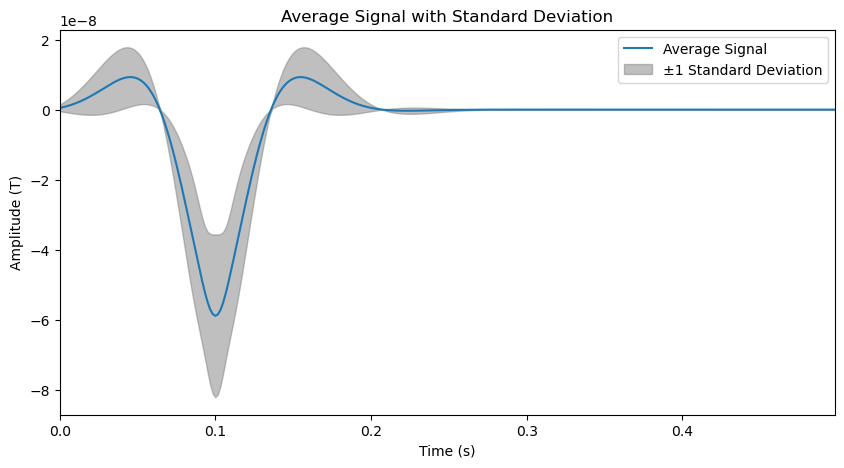

In [10]:
# epoch length is too long , change plot_samp when wavelet is wider to visualise betetr
plot_samp = 300
times_plot = times[:plot_samp]

average_signal = np.mean(signal_matrix[:, :plot_samp], axis=0)
std_signal = np.std(signal_matrix[:, :plot_samp], axis=0)

plt.figure(figsize=(10, 5))
plt.plot(times_plot, average_signal, label='Average Signal')
plt.fill_between(times_plot, average_signal - std_signal, average_signal + std_signal, color='gray', alpha=0.5, label='±1 Standard Deviation')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (T)')
plt.title('Average Signal with Standard Deviation')
plt.legend()
plt.xlim([times_plot[0], times_plot[-1]])  # Adjust x-axis limits
plt.savefig('average_signal_with_std.png', dpi=400)
plt.show()

## Location of label and vertices

In [71]:
# Visualisation of selected dipoles and label
brain_kwargs = dict(alpha=0.2, background="white", cortex="low_contrast",title="Vertices in Aud Cortex Present in SOurce Space")
brain = mne.viz.Brain("sample", subjects_dir=subjects_dir, **brain_kwargs)
#brain.add_foci(vertices_in_aud_cortex,hemi="lh",coords_as_verts=True,color="red",scale_factor=0.2)
brain.add_label(
        label_primary_aud_cortex[0], hemi="lh", color="green", subdir="/home/hp/mne_data/MNE-sample-data/subjects/fsaverage/label/lh.aparc.a2009s",borders=False)

brain.add_foci(saving_vertices,hemi="lh",coords_as_verts=True,color="blue",scale_factor=0.2,alpha=1)


## Events plot

In [ ]:
events = mne.find_events(raw_dipole, initial_event=True,min_duration=0)
fig = mne.viz.plot_events(
    events, sfreq=raw.info["sfreq"], first_samp=raw_sim.first_samp
)

## Example evoked plots

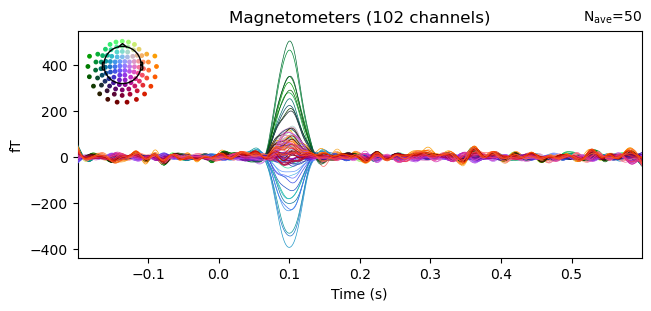

In [51]:
fig= evoked_dict["epoch_1"].plot()

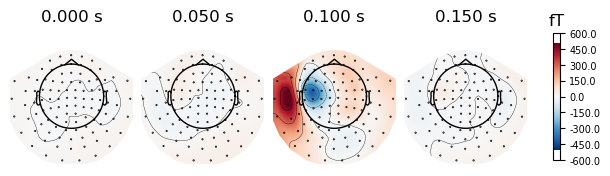

In [52]:
fig=evoked_dict["epoch_1"].plot_topomap(np.array([0.0,0.05,0.1,0.15]))

Computing rank from covariance with rank=None
    Using tolerance 2.5e-14 (2.2e-16 eps * 102 dim * 1.1  max singular value)
    Estimated rank (mag): 102
    MAG: rank 102 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 2.6e-12 (2.2e-16 eps * 204 dim * 56  max singular value)
    Estimated rank (grad): 204
    GRAD: rank 204 computed from 204 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 4.8e-14 (2.2e-16 eps * 60 dim * 3.6  max singular value)
    Estimated rank (eeg): 60
    EEG: rank 60 computed from 60 data channels with 0 projectors


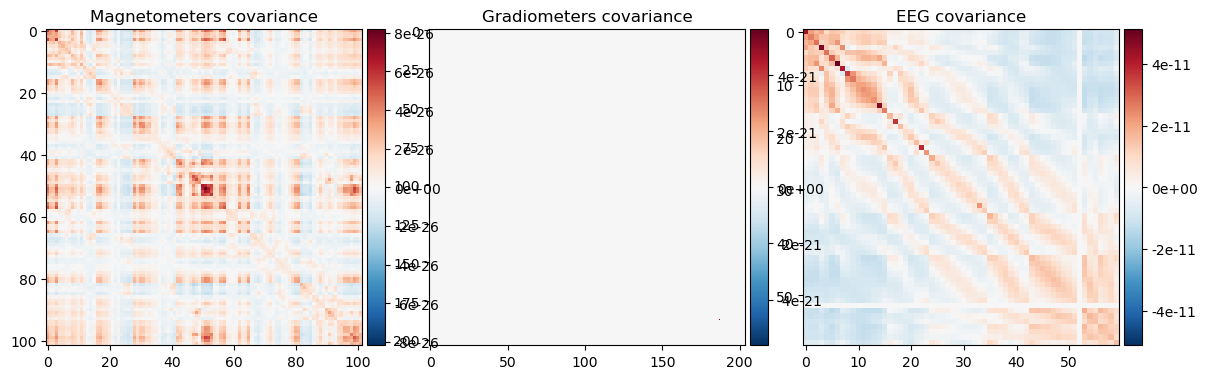

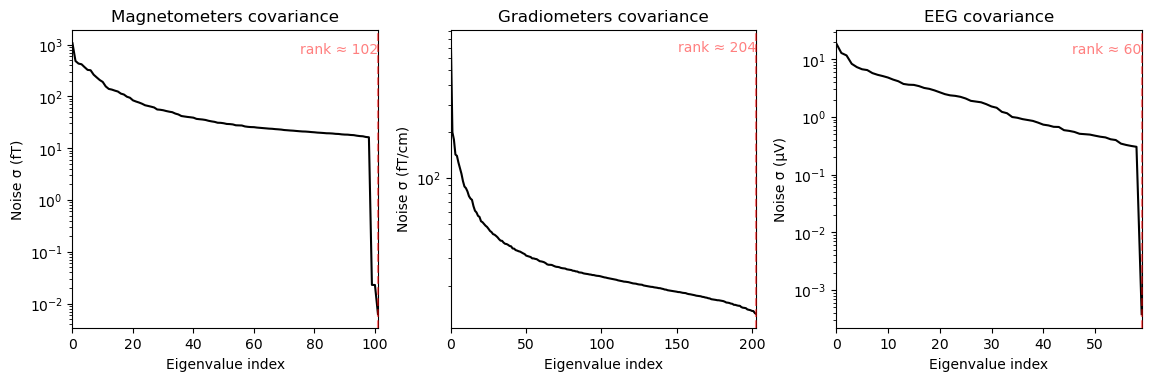

(<Figure size 1140x370 with 6 Axes>, <Figure size 1140x370 with 3 Axes>)

In [25]:
cov.plot(raw.info)